# SETI as One-Shot Hypothesis Testing Notebook

This notebook implements one-shot hypothesis testing between standard observed meteors for meteor burst communications and observed meteors if an ETI was sending a consistent stream of small meteors. This notebook both can be used to reproduce the plots in the paper, but also can be altered out of curiousity.

In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.io

### Definition of $\zeta^{\varepsilon}_{H}(P_0 || P_1)$ function

First we define the $\varepsilon$-hypothesis testing SDP, $\zeta_{H}^{\varepsilon}(P_0||P_1)$ (Eqn. 3 of the paper). A quantum version is included for completeness, though we only ever use the classical version

In [2]:
def varepHypothesisTestingQuantum(ve,null_hyp,alt_hyp):
    #First We make some quick checks on the input 
    #NOTE: To save time, we don't check if the hypothesis are PSD, which they need to be
    dim = np.shape(null_hyp)[0]
    if dim != np.shape(null_hyp)[1]:
        print("Error: Please make sure your null hypothesis is square.")
    elif (dim != np.shape(alt_hyp)[0] or dim != np.shape(alt_hyp)[1]):
        print("Error: Please make sure alternative and null hypotheses have same dimension.")
    elif ve >= 1 or ve <= 0 :
        print("Error: varepsilon must be strictly between 0 and 1.")
    elif np.trace(null_hyp) < 0 or np.trace(null_hyp) > 1 :
        print("Error: null_hyp must have trace between 0 and 1 inclusive.")
    elif np.trace(alt_hyp) > 1 :
        print("Warning: alt_hyp is not a (sub)-normalized density matrix.")
        print("Please verify you want to do this by commenting out this elif statement.")
    elif np.trace(alt_hyp) < 0 :
        print("Error: alt_hyp must have trace greater than 0.")
    else:
        #Given that the input seems good, we go ahead with our SDP
        #We take the real part of the traces because cvxpy doesn't
        #seem to know it will be a real value
        A = cp.Variable((dim,dim), hermitian = True)
        constraints = [A >> 0]
        constraints += [np.identity(dim) >> A]
        constraints += [
            cp.real(cp.trace(null_hyp @ A)) >= 1 - ve
        ]
        prob = cp.Problem(cp.Minimize(cp.real(cp.trace(A @ alt_hyp))),
                              constraints)
        prob.solve()
            
        return [prob.value, A.value]
            
        
def varepHypothesisTestingClassical(ve,null_hyp,alt_hyp):
        #Again we check the input first
        dim = len(null_hyp)
        if np.shape(null_hyp) != (dim,) or np.shape(alt_hyp) != (dim,):
            print("Error: Make sure the null and alternative hypotheses are vectors.")
        elif sum(null_hyp) > 1 or sum(alt_hyp) > 1:
            print("Error: The null and alternative hypotheses must be sub-normalized probability distributions.")
        elif ve >= 1 or ve <= 0 :
            print('Error: varepsilon must be strictly between 0 and 1.')
        elif np.amin(null_hyp) < 0 or np.amin(alt_hyp) < 0:
            print("Error: The null and alternative hypotheses must only contain non-negative elements.")
        else:
            #Given that the input seems good, we go ahead with our LP
            a = cp.Variable(dim, nonneg = True)
            constraints = [a <= np.ones(dim)]
            constraints += [(null_hyp.T@a) >= 1 - ve]
            prob = cp.Problem(cp.Minimize(alt_hyp.T@a),
                          constraints)
            prob.solve()
            
            return [prob.value, a.value]

This is for testing the functions if you'd like

In [3]:
#These are classical input
p0 = np.array([0.75,0.25])
p1 = np.array([0.2,0.8])

#These are quantum versions of the same classical data
rhoCl = np.array([[0.75,0],[0, 0.25]])
sigmaCl = np.array([[0.2,0],[0,0.8]])

classical = varepHypothesisTestingClassical(0.1,p0,p1)
quantumClassical =varepHypothesisTestingQuantum(0.1,rhoCl,sigmaCl)

#These are proper quantum states (eigenstates of the pauli X and Y bases)
rho = np.array([[0.5, 0.5j],[-0.5j,0.5]])
sigma = np.array([[0.5, 0.5],[0.5,0.5]])

fullyQuantum = varepHypothesisTestingQuantum(0.1,rho,sigma)

print(classical)
print(quantumClassical)
print(fullyQuantum)

WARN: A->p (column pointers) not strictly increasing, column 3 empty
WARN: A->p (column pointers) not strictly increasing, column 6 empty
WARN: A->p (column pointers) not strictly increasing, column 3 empty
WARN: A->p (column pointers) not strictly increasing, column 6 empty
[0.6799999999157452, array([1. , 0.6])]
[0.6799999999048214, array([[1. +0.j, 0. +0.j],
       [0. +0.j, 0.6+0.j]])]
[0.1999999997437612, array([[ 0.5+0.j , -0.3+0.4j],
       [-0.3-0.4j,  0.5+0.j ]])]


### Data Generation

We now build the data. As explained in the paper, officially we first find some arbitrarily large value for altering the Poisson distribution, and then we apply a smaller cutoff that either allows the numerics to handle it or just seems sufficient given the tail of our distributions. In this case, the cutoff is just determined by the tail of the distributions.

We gather data for two Poison parameters $\lambda$, three choices of false-positive thresholds $\varepsilon$, and for small numbers of meteor signals determined by max_ETI_meteors

In [4]:
#Function that returns the probability of n outcomes for a Poisson distribution
def nProb(n,lam_param):
    return (lam_param**n * math.exp(-lam_param))/math.factorial(n)

def generateDistributions(cutoff,lam_param,ETI_meteors):
    null_hyp = np.zeros(cutoff)
    alt_hyp = np.zeros(cutoff)
    for i in range(cutoff):
        prob_init = nProb(i,lam_param)
        null_hyp[i] = prob_init
        if i + ETI_meteors <= cutoff-1:
            alt_hyp[i+ETI_meteors] = prob_init
            
    return [null_hyp, alt_hyp]
    
lam_params = [3,6]               #The Poisson parameter, lambda
max_ETI_meteors = 8         #Maximum number of extra meteors per unit interval
cutoff = 40                 #Space projected onto (tails are much smaller at this point; see below)
ve_vals = [0.1,0.01,0.001]  #

data = np.zeros((2,3,max_ETI_meteors+1))
for lam_ctr in range(0,2):
    for ve_ctr in range(0,3):
        for meteor_num in range(0,max_ETI_meteors+1):
            [null_hyp, alt_hyp] = generateDistributions(cutoff,lam_params[lam_ctr],meteor_num)
            [betan, decision_function] = varepHypothesisTestingClassical(ve_vals[ve_ctr],null_hyp,alt_hyp)
            data[lam_ctr,ve_ctr,meteor_num] = betan

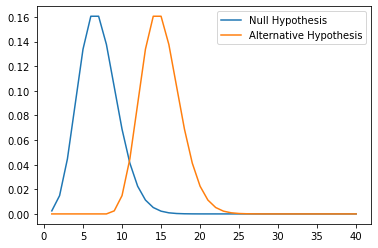

In [5]:
#This just shows you that for the largest lambda and largest number of meteors, 
#the tail is still suppressed at the cutoff (it also shows the overlap)
xaxis= list(range(1, cutoff+1))
# plot lines
plt.plot(xaxis, null_hyp, label = "Null Hypothesis")
plt.plot(xaxis, alt_hyp, label = "Alternative Hypothesis")
plt.legend()
plt.show()

### Data Plotting

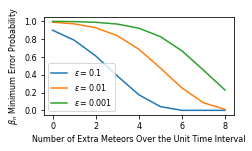

In [24]:
#For lambda = 3
xaxis = range(0,max_ETI_meteors+1)
# plot lines
#plt.gcf().subplots_adjust(bottom=0.3)
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(3.4,1.8)) #3.4252,2.28346666667
plt.plot(xaxis, data[0,0], label = r"$\varepsilon = 0.1$")
plt.plot(xaxis, data[0,1], label = r"$\varepsilon = 0.01$")
plt.plot(xaxis, data[0,2], label = r"$\varepsilon = 0.001$")
#plt.title(r"Probability of Missing ETI Signal with Optimal Decision Function ($\beta_n$)" 
#          "\n as a Function of ETI Injected Meteors for Null Hypothesis" r"$\sim$Pois(3)")
plt.ylabel(r'$\beta_n$ Minimum Error Probability')
plt.xlabel('Number of Extra Meteors Over the Unit Time Interval')
plt.legend()

#If you'd like to save the figure
plt.savefig('ETIMeteorsLambda3.png', format='png',bbox_inches='tight', dpi=1200) #

plt.show()

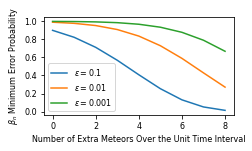

In [25]:
#For lambda = 6
xaxis = range(0,max_ETI_meteors+1)
# plot lines
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(3.4,1.8)) #3.4252,2.28346666667
plt.plot(xaxis, data[1,0], label = r"$\varepsilon = 0.1$")
plt.plot(xaxis, data[1,1], label = r"$\varepsilon = 0.01$")
plt.plot(xaxis, data[1,2], label = r"$\varepsilon = 0.001$")
#plt.title(r"Probability of Missing ETI Signal with Optimal Decision Function ($\beta_n$)" 
#          "\n as a Function of ETI Injected Meteors for Null Hypothesis" r"$\sim$Pois(6)")
plt.ylabel(r'$\beta_n$ Minimum Error Probability')
plt.xlabel('Number of Extra Meteors Over the Unit Time Interval')
plt.legend()

#If you'd like to save the figure
plt.savefig('ETIMeteorsLambda6.png', format='png', bbox_inches='tight', dpi=1200)

plt.show()